## 集成算法

集成已迅速成为应用机器学习中最热门和最流行的方法之一。尤其是在竞赛和提高模型精度方向！

推荐阅读：http://ml-ensemble.com/

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

if sys.platform == 'win32':
    filepath = r"C:\Users\17634\Desktop\Files\集成算法\input.csv"
else:
    filepath = r"/Users/wangrui/Desktop/Files/唐宇迪课程资料/集成算法/input.csv"

In [3]:
### Import data
# Always good to set a seed for reproducibility
SEED = 222
np.random.seed(SEED)

df = pd.read_csv(filepath)

### Training and test set
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

def get_train_test(test_size=0.95):
    """Split Data into train and test sets."""
    y = 1 * (df.cand_pty_affiliation == "REP")
    X = df.drop(["cand_pty_affiliation"], axis=1)
    X = pd.get_dummies(X, sparse=False) # sparse=True转为矩阵
    # 去除方差为0的列
    t = X.nunique()
    X.drop(t[t == 1].index, axis=1, inplace=True)
    return train_test_split(X, y, test_size=test_size, random_state=SEED)

xtrain, xtest, ytrain, ytest = get_train_test()

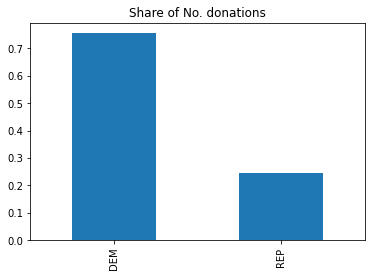

In [4]:
df.cand_pty_affiliation.value_counts(normalize=True).plot(kind='bar', title='Share of No. donations')

In [5]:
import pydotplus
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from IPython.display import Image
from sklearn.metrics import roc_auc_score

def print_graph(clf, feature_names):
    """Print decision tree"""
    graph = export_graphviz(
        clf,
        label='root',
        proportion=True,
        impurity=False,
        feature_names=feature_names,
        class_names={0: 'D', 1: 'R'},
        filled=True,
        rounded=True
    )
    graph = pydotplus.graph_from_dot_data(graph)
    return Image(graph.create_png())

In [6]:
t1 = DecisionTreeClassifier(max_depth=1, random_state=SEED)
t1.fit(xtrain, ytrain)
p = t1.predict_proba(xtest)[:, 1]  #预测是标签值是1的概率
print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Decision tree ROC-AUC score: 0.672


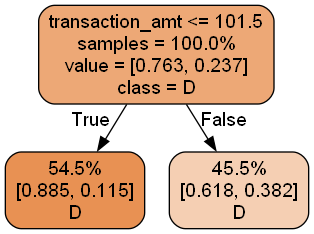

In [7]:
print_graph(t1, xtrain.columns)

In [8]:
t2 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t2.fit(xtrain, ytrain)
p = t2.predict_proba(xtest)[:, 1]
print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Decision tree ROC-AUC score: 0.751


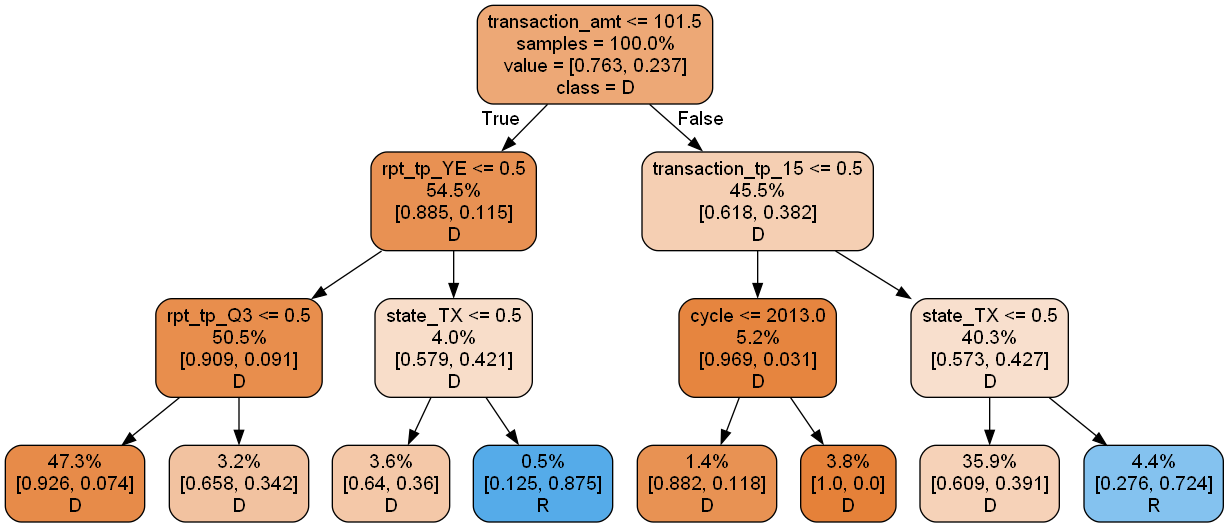

In [9]:
print_graph(t2, xtrain.columns)

In [10]:
drop = ["transaction_amt"]
xtrain_slim = xtrain.drop(drop, 1)
xtest_slim = xtest.drop(drop, 1)
t3 = DecisionTreeClassifier(max_depth=3, random_state=SEED)
t3.fit(xtrain_slim, ytrain)
p = t3.predict_proba(xtest_slim)[:, 1]
print("Decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Decision tree ROC-AUC score: 0.740


C:\Users\17634\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
C:\Users\17634\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  This is separate from the ipykernel package so we can avoid doing imports until


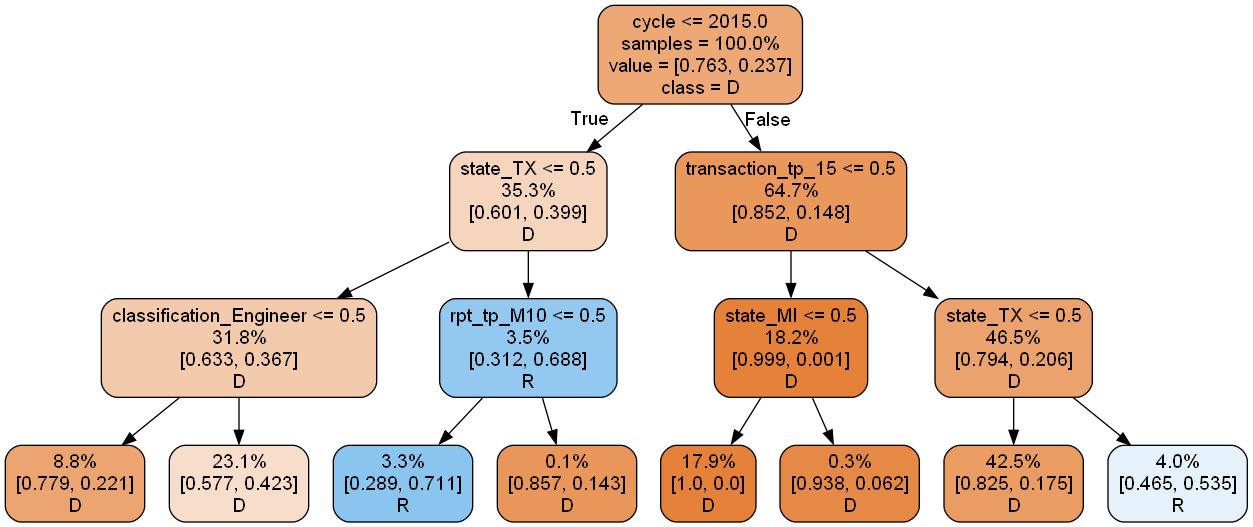

In [11]:
print_graph(t3, xtrain_slim.columns)

In [12]:
xtrain.columns

Index(['cycle', 'transaction_amt', 'cand_office_st_AK', 'cand_office_st_AL',
       'cand_office_st_AR', 'cand_office_st_AZ', 'cand_office_st_CA',
       'cand_office_st_CO', 'cand_office_st_CT', 'cand_office_st_DC',
       ...
       'state_VI', 'state_VT', 'state_WA', 'state_WI', 'state_WV', 'state_WY',
       'state_ZZ', 'classification_Engineer', 'classification_Math-Stat',
       'classification_Scientist'],
      dtype='object', length=158)

In [13]:
p0 = t2.predict_proba(xtest)

In [14]:
p1 = t2.predict_proba(xtest)[:, 1]
p2 = t3.predict_proba(xtest_slim)[:, 1]
p = np.mean([p1, p2], axis=0)
print(p)
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

[0.40699532 0.0368176  0.30585183 ... 0.30585183 0.30585183 0.0368176 ]
Average of decision tree ROC-AUC score: 0.783


In [15]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=10,
    max_features=3,
    random_state=SEED
)

rf.fit(xtrain, ytrain)
p = rf.predict_proba(xtest)[:, 1]
print("Average of decision tree ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Average of decision tree ROC-AUC score: 0.844


In [16]:
ytest.shape

(95000,)

In [17]:
# A host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.kernel_approximation import RBFSampler
from sklearn.pipeline import make_pipeline


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    svc = SVC(C=100, probability=True)
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=100, random_state=SEED)
    nn = MLPClassifier((80, 10), early_stopping=False, random_state=SEED)
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    rf = RandomForestClassifier(n_estimators=10, max_features=3, random_state=SEED)

    models = {'svm': svc,
              'knn': knn,
              'naive bayes': nb,
              'mlp-nn': nn,
              'random forest': rf,
              'gbm': gb,
              'logistic': lr,
              }

    return models

def train_predict(models):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(models)))
    P = pd.DataFrame(P)

    print("Fitting models.")
    cols = list()
    for i, (name, m) in enumerate(models.items()):
        print("%s..." % name, end=" ", flush=False)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        cols.append(name)
        print("done")

    P.columns = cols
    print("Done.\n")
    return P


def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        print("%-26s: %.3f" % (m, score))
    print("Done.\n")

In [18]:
models = get_models()
P = train_predict(models)
score_models(P, ytest)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... 

C:\Users\17634\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


done
Done.

Scoring models.
svm                       : 0.845
knn                       : 0.785
naive bayes               : 0.803
mlp-nn                    : 0.873
random forest             : 0.844
gbm                       : 0.878
logistic                  : 0.853
Done.



In [19]:
P.corr()

,svm,knn,naive bayes,mlp-nn,random forest,gbm,logistic
svm,1.000000,0.083199,0.086900,0.132166,0.096064,0.120399,0.132819
knn,0.083199,1.000000,0.349902,0.592038,0.626144,0.641347,0.568565
naive bayes,0.086900,0.349902,1.000000,0.597138,0.445388,0.533404,0.528161
mlp-nn,0.132166,0.592038,0.597138,1.000000,0.735542,0.905112,0.896589
random forest,0.096064,0.626144,0.445388,0.735542,1.000000,0.777888,0.730648
gbm,0.120399,0.641347,0.533404,0.905112,0.777888,1.000000,0.865821
logistic,0.132819,0.568565,0.528161,0.896589,0.730648,0.865821,1.000000


In [20]:
print("Ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.mean(axis=1)))

Ensemble ROC-AUC score: 0.883


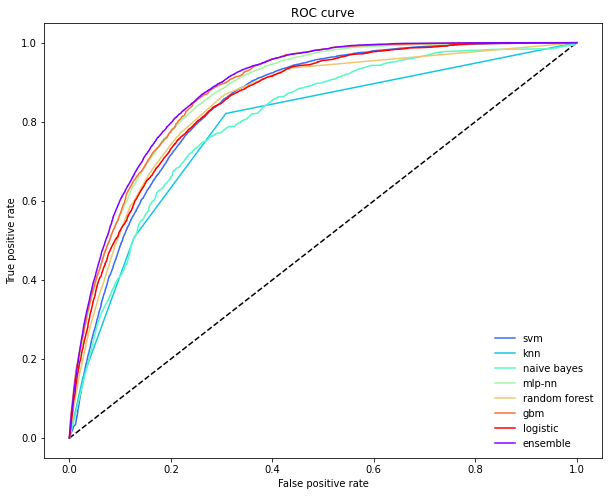

In [21]:
from sklearn.metrics import roc_curve

def plot_roc_curve(ytest, P_base_learners, P_ensemble, labels, ens_label):
    """Plot the roc curve for base learners and ensemble."""
    plt.figure(figsize=(10, 8))
    plt.plot([0, 1], [0, 1], 'k--')

    cm = [plt.cm.rainbow(i)
          for i in np.linspace(0, 1.0, P_base_learners.shape[1] + 1)]

    for i in range(P_base_learners.shape[1]):
        p = P_base_learners[:, i]
        fpr, tpr, _ = roc_curve(ytest, p)
        plt.plot(fpr, tpr, label=labels[i], c=cm[i + 1])

    fpr, tpr, _ = roc_curve(ytest, P_ensemble)
    plt.plot(fpr, tpr, label=ens_label, c=cm[0])

    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(frameon=False)
    plt.show()


plot_roc_curve(ytest, P.values, P.mean(axis=1), list(P.columns), "ensemble")

In [22]:
## 此用法很新颖
P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))

,svm,knn,naive bayes,mlp-nn,random forest,gbm,logistic
False,0.999421,0.779621,0.817011,0.873253,0.770526,0.850284,0.822421
True,0.000579,0.220379,0.182989,0.126747,0.229474,0.149716,0.177579


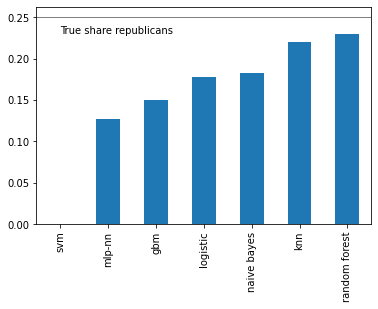

In [23]:
p = P.apply(lambda x: 1*(x >= 0.5).value_counts(normalize=True))
p.index = ["DEM", "REP"]
p.loc["REP", :].sort_values().plot(kind="bar")
plt.axhline(0.25, color="k", linewidth=0.5)
plt.text(0., 0.23, "True share republicans")
plt.show()

In [24]:
# 剔除最差的算法
include = [c for c in P.columns if c != "mlp-nn"]
print("Truncated ensemble ROC-AUC score: %.3f" % roc_auc_score(ytest, P.loc[:, include].mean(axis=1)))

Truncated ensemble ROC-AUC score: 0.881


# Stacking模型

In [25]:
# 1. 定义基础模型
base_learners = get_models()

In [26]:
# 2.定义我们的权重分配模型（第二层架构）
meta_learner = GradientBoostingClassifier(
    n_estimators=1000,
    loss="exponential",
    max_features=4,
    max_depth=3,
    subsample=0.5,
    learning_rate=0.005,
    random_state=SEED
)

In [27]:
# 3.将基础模型分成两部分，主要供第二层来使用
xtrain_base, xpred_base, ytrain_base, ypred_base = train_test_split(xtrain, ytrain, test_size=0.5, random_state=SEED)

In [28]:
# 4.训练我们的基础模型
def train_base_learners(base_learners, inp, out, verbose=True):
    """Train all base learners in the library."""
    if verbose: print("Fitting models.")
    for i, (name, m) in enumerate(base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        m.fit(inp, out)
        if verbose: print("done")

train_base_learners(base_learners, xtrain_base, ytrain_base)

Fitting models.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


C:\Users\17634\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [29]:
# 5.准备二阶段权重分配分类器的训练数据
def predict_base_learners(pred_base_learners, inp, verbose=True):
    """Generate a prediction matrix."""
    P = np.zeros((inp.shape[0], len(pred_base_learners)))

    if verbose: print("Generating base learner predictions.")
    for i, (name, m) in enumerate(pred_base_learners.items()):
        if verbose: print("%s..." % name, end=" ", flush=False)
        p = m.predict_proba(inp)
        # With two classes, need only predictions for one class
        P[:, i] = p[:, 1]
        if verbose: print("done")

    return P

P_base = predict_base_learners(base_learners, xpred_base)

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done


In [30]:
# 6.训练二阶段得出分类结果！
meta_learner.fit(P_base, ypred_base)

GradientBoostingClassifier(learning_rate=0.005, loss='exponential',
                           max_features=4, n_estimators=1000, random_state=222,
                           subsample=0.5)

In [31]:
def ensemble_predict(base_learners, meta_learner, inp, verbose=True):
    """Generate predictions from the ensemble."""
    P_pred = predict_base_learners(base_learners, inp, verbose=verbose)
    return P_pred, meta_learner.predict_proba(P_pred)[:, 1]

P_pred, p = ensemble_predict(base_learners, meta_learner, xtest)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Generating base learner predictions.
svm... done
knn... done
naive bayes... done
mlp-nn... done
random forest... done
gbm... done
logistic... done

Ensemble ROC-AUC score: 0.879


划分为训练集和测试集虽然能满足咱们的要求，但是好像损失了一部分数据啊？那怎么办？用交叉验证来搞定！

In [32]:
from sklearn.base import clone

def stacking(base_learners, meta_learner, X, y, generator):
    """Simple training routine for stacking."""

    # Train final base learners for test time
    print("Fitting final base learners...", end="")
    train_base_learners(base_learners, X, y, verbose=False)
    print("done")

    # Generate predictions for training meta learners
    # Outer loop:
    print("Generating cross-validated predictions...")
    cv_preds, cv_y = [], []
    for i, (train_idx, test_idx) in enumerate(generator.split(X)):

        fold_xtrain, fold_ytrain = X[train_idx, :], y[train_idx]
        fold_xtest, fold_ytest = X[test_idx, :], y[test_idx]

        # Inner loop: step 4 and 5
        fold_base_learners = {name: clone(model)
                              for name, model in base_learners.items()}
        train_base_learners(
            fold_base_learners, fold_xtrain, fold_ytrain, verbose=False)

        fold_P_base = predict_base_learners(
            fold_base_learners, fold_xtest, verbose=False)

        cv_preds.append(fold_P_base)
        cv_y.append(fold_ytest)
        print("Fold %i done" % (i + 1))

    print("CV-predictions done")

    # Be careful to get rows in the right order
    cv_preds = np.vstack(cv_preds) #垂直拼接
    cv_y = np.hstack(cv_y) #水平拼接

    # Train meta learner
    print("Fitting meta learner...", end="")
    meta_learner.fit(cv_preds, cv_y)
    print("done")

    return base_learners, meta_learner

In [33]:
from sklearn.model_selection import KFold

# Train with stacking
cv_base_learners, cv_meta_learner = stacking(
    get_models(), clone(meta_learner), xtrain.values, ytrain.values, KFold(2))

P_pred, p = ensemble_predict(cv_base_learners, cv_meta_learner, xtest, verbose=False)
print("\nEnsemble ROC-AUC score: %.3f" % roc_auc_score(ytest, p))

Fitting final base learners...

C:\Users\17634\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


done
Generating cross-validated predictions...


C:\Users\17634\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Fold 1 done


C:\Users\17634\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Fold 2 done
CV-predictions done
Fitting meta learner...done


C:\Users\17634\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\17634\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\17634\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\17634\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
C:\Users\17634\Anaconda3\lib\site-packages\sklearn\base.py:444: UserWarning: X has feature names, but RandomFo


Ensemble ROC-AUC score: 0.888


现在我们来想一想，这样的方法有啥问题呢？是不是速度会比较慢呀！推荐大家用下面的并行方法，速度大大提升！

In [34]:
base_learners.values()

dict_values([SVC(C=100, probability=True), KNeighborsClassifier(n_neighbors=3), GaussianNB(), MLPClassifier(hidden_layer_sizes=(80, 10), random_state=222), RandomForestClassifier(max_features=3, n_estimators=10, random_state=222), GradientBoostingClassifier(random_state=222), LogisticRegression(C=100, random_state=222)])

In [35]:
from mlens.ensemble import SuperLearner

# Instantiate the ensemble with 10 folds
sl = SuperLearner(
    folds=10,
    random_state=SEED,
    verbose=2,
    backend='multiprocessing'
)

# Add the base learners and the meta learner
sl.add(list(base_learners.values()), proba=True)
sl.add_meta(meta_learner, proba=True)

# Train the ensemble
sl.fit(xtrain, ytrain)

# Predict the test set
p_sl = sl.predict_proba(xtest)

print("\nSuper Learner ROC-AUC score: %.3f" % roc_auc_score(ytest, p_sl[:, 1]))


Fitting 2 layers


[MLENS] backend: threading
[MLENS] Found 1 residual cache(s):
        1 (4096): C:\Users\17634\AppData\Local\Temp\.mlens_tmp_cache_jkee14a5
        Total size: 4096
[MLENS] Removing... done.


Processing layer-1             done | 00:01:04
Processing layer-2             done | 00:00:03
Fit complete                        | 00:01:08

Predicting 2 layers
Processing layer-1             done | 00:00:45
Processing layer-2             done | 00:00:01
Predict complete                    | 00:00:48

Super Learner ROC-AUC score: 0.890


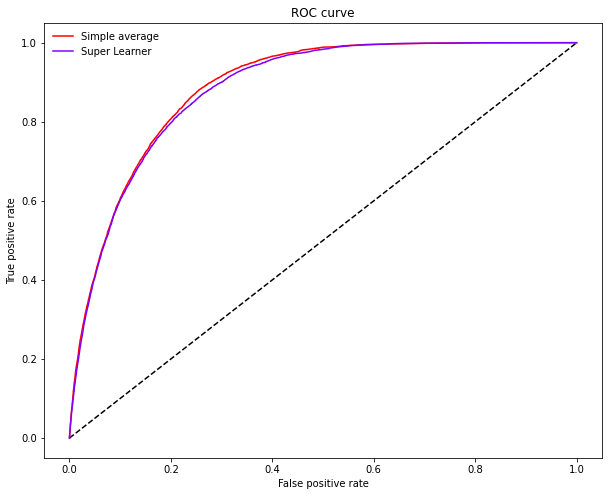

In [36]:
plot_roc_curve(ytest, p.reshape(-1, 1), P.mean(axis=1), ["Simple average"], "Super Learner")